<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Experiment-description" data-toc-modified-id="Experiment-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Experiment description</a></span></li><li><span><a href="#Code-definitions-and-initializations" data-toc-modified-id="Code-definitions-and-initializations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Code definitions and initializations</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Database-initialization-and-loading-experiment" data-toc-modified-id="Database-initialization-and-loading-experiment-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Database initialization and loading experiment</a></span></li><li><span><a href="#Live-plotting-initialization" data-toc-modified-id="Live-plotting-initialization-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Live plotting initialization</a></span></li></ul></li><li><span><a href="#Code-of-the-experiment-(one-channel,-one-marker)" data-toc-modified-id="Code-of-the-experiment-(one-channel,-one-marker)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Code of the experiment (one channel, one marker)</a></span><ul class="toc-item"><li><span><a href="#Create-AWG-signal" data-toc-modified-id="Create-AWG-signal-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create AWG signal</a></span></li><li><span><a href="#Hook-up-AWG-and-lock-in's-in-a-class" data-toc-modified-id="Hook-up-AWG-and-lock-in's-in-a-class-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Hook up AWG and lock-in's in a class</a></span></li><li><span><a href="#Setup-a-station" data-toc-modified-id="Setup-a-station-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Setup a station</a></span></li></ul></li><li><span><a href="#Lockin-+-MIDAS-(TWO-markers-for-one-channel)" data-toc-modified-id="Lockin-+-MIDAS-(TWO-markers-for-one-channel)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Lockin + MIDAS (TWO markers for one channel)</a></span><ul class="toc-item"><li><span><a href="#Create-AWG-signal" data-toc-modified-id="Create-AWG-signal-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Create AWG signal</a></span></li><li><span><a href="#Hook-up-AWG-and-lock-in's-in-a-class" data-toc-modified-id="Hook-up-AWG-and-lock-in's-in-a-class-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Hook up AWG and lock-in's in a class</a></span></li><li><span><a href="#Setup-a-station" data-toc-modified-id="Setup-a-station-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Setup a station</a></span></li></ul></li><li><span><a href="#Continuation-of-definitions" data-toc-modified-id="Continuation-of-definitions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Continuation of definitions</a></span><ul class="toc-item"><li><span><a href="#Define-a-meta-instrument-with-measurable/interesting-paramters" data-toc-modified-id="Define-a-meta-instrument-with-measurable/interesting-paramters-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Define a meta-instrument with measurable/interesting paramters</a></span></li><li><span><a href="#Set-up-lock-in's-for-the-measurement" data-toc-modified-id="Set-up-lock-in's-for-the-measurement-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Set up lock-in's for the measurement</a></span><ul class="toc-item"><li><span><a href="#Main-lock-in" data-toc-modified-id="Main-lock-in-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Main lock-in</a></span></li><li><span><a href="#Lock-in-2" data-toc-modified-id="Lock-in-2-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Lock-in 2</a></span></li><li><span><a href="#Lock-in-3" data-toc-modified-id="Lock-in-3-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Lock-in 3</a></span></li></ul></li><li><span><a href="#Empty-cell-for-playing-with-objects" data-toc-modified-id="Empty-cell-for-playing-with-objects-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Empty cell for playing with objects</a></span></li><li><span><a href="#Run-measurement-and-get-data" data-toc-modified-id="Run-measurement-and-get-data-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Run measurement and get data</a></span></li><li><span><a href="#Plot-all-acquired-data-(from-database)" data-toc-modified-id="Plot-all-acquired-data-(from-database)-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Plot all acquired data (from database)</a></span></li><li><span><a href="#Plot-all-acquired-data-(from-memory)" data-toc-modified-id="Plot-all-acquired-data-(from-memory)-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Plot all acquired data (from memory)</a></span></li><li><span><a href="#Average-acquired-data-for-accuracy" data-toc-modified-id="Average-acquired-data-for-accuracy-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Average acquired data for accuracy</a></span></li></ul></li><li><span><a href="#Miscellaneous" data-toc-modified-id="Miscellaneous-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Miscellaneous</a></span><ul class="toc-item"><li><span><a href="#A-helper-measurement-that-collects-MANY-samples-starting-from-a-trigger" data-toc-modified-id="A-helper-measurement-that-collects-MANY-samples-starting-from-a-trigger-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>A helper measurement that collects MANY samples starting from a trigger</a></span></li></ul></li></ul></div>

# Experiment description

The experiment goal is to measure transistor source-drain current while varying the gate voltage.

The gate voltage is supplied as a staircase ramp using an AWG. Marker signals (a.k.a. triggers) are used within each step of the fast ramp for to triggering 3 lock-in amplifiers to perform a measurement of a single data point (lock-ins are triggered on the falling edge of the marker signal; the "high" voltage of the marker is set to a big value, otherwise lock-in might not react in a robust manner). 

The drain is modulated by the lock-ins internal sine wave generator, and source is plugged as an input to the lock-in. For simplicity, all the three lock-ins measure the same "pin" of the device, and the acquisition parameters are the same (moreover, the signal of one of the lock-in amplifiers is used as a reference signal for the other two).

For the sake of accuracy, the fast staircase ramp is repeated, and the average of the acquired data points is calculated (per step of the staircase, of course).

As it is clear from above, the gate voltage ramp is swept by hardware. To make things more interesting, the frequency of the lock-in amplifiers is swept in software.

The goal of this exercise is to develop a vision on how such experiments/measurements can be neatly defined in software through QCoDeS. The rationale for this goal is that V0 characterization experiments will look quite like this example experiment.

The AWG signal output is quite limited (up to ~1Vp-p), hence the transistor won't react significantly on the fast ramp. In order to fix this, a pre-amplifier is used to multiply the AWG signal by 10x.

We measure the source-drain current, but in the notebook it is referred to as "source-drain current as voltage" (or alike) in order not to focus on the conversion which is not the point of this exercise.

# Code definitions and initializations

## Imports

In [1]:
%matplotlib notebook

from v0_utils.hwsweep import \
    HardwareSweep
    
from v0_utils.sequence_generators import \
    RepeatingStaircaseRampGenerator, \
    RepeatingStaircaseRampGeneratorTwoTriggers
    
from v0_utils.awg_sequencers import \
    OneChannelOneMarkerAwgSequencer, \
    AwgSequencer, \
    OneChannelTwoMarkerAwgSequencer

from v0_utils.qcodes_tools import \
    instrument_factory, init_or_create_database, load_or_create_experiment, \
    add_parameter_to_instrument, \
    DelegateParameter, VirtualInstrument

# Useful tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from typing import Union, List, Type
from scipy.signal import savgol_filter
import time

# For live plotting and plotting from database
import plottr
from plottr.qcodes_dataset import QcodesDatasetSubscriber as LivePlotSubscriber

# qcodes features
import qcodes
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.utils.validators import Numbers
    
# Drivers
from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208
from qcodes.instrument_drivers.stanford_research.SR860 import SR860
from qcodes.instrument_drivers.stanford_research.SR86x import SR86x

## Database initialization and loading experiment

In [2]:
init_or_create_database(
    r'D:\OneDrive\BF2\Data\lock_in_hardware_sweep_experiments.db')

experiment = load_or_create_experiment(
    experiment_name='lock_in_hardware_sweep',
    sample_name='test')

## Live plotting initialization

In [3]:
plottr.tools.start_listener()

AttributeError: module 'plottr' has no attribute 'tools'

# Code of the experiment (one channel, one marker)

## Create AWG signal

<IPython.core.display.Javascript object>


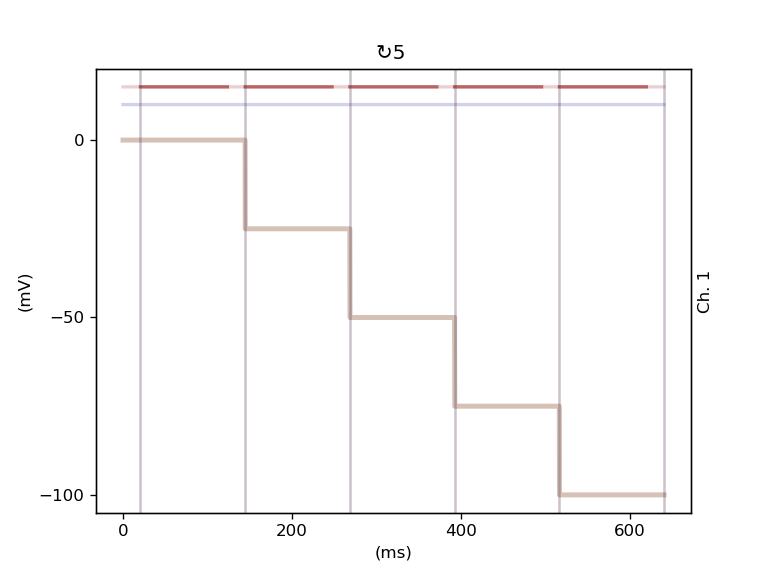

In [4]:
fast_ramp = RepeatingStaircaseRampGenerator('fast_staircase_ramp')

fast_ramp.sample_rate(10e3)
fast_ramp.start_ramp_voltage(0)
fast_ramp.finish_ramp_voltage(-0.1)
fast_ramp.n_steps(5)  # 30
fast_ramp.n_repetitions(5)  # 20
fast_ramp.settlement_time(0.103)  # 0.103
fast_ramp.lockin_integration_time(0.021)  # 0.021
fast_ramp.restart_compensation(0.2 * fast_ramp.settlement_time())

# Convenient vectors for plotting
time_axis_points = fast_ramp.get_trigger_moments_vector()
gate_voltage_points = fast_ramp.values_vector()

# Sanity check :)
fast_ramp.plot_broadbean_sequence()

## Hook up AWG and lock-in's in a class

In [5]:
class AwgLockInVoltageRampSweep(HardwareSweep):
    """
    This class implements "hardware" sweep that is performed by AWG sequencer, 
    and 3 lock-ins are measuring values while AWG is emitting a signal.
    
    Structure of this object:
    * The object of this class holds references to AWG sequencer and to the lock-ins.
    * Moreover, it defines 3 parameters which correspond to the outputs of the 3 lock-ins.
    * The 'run' method implements the actual measurement where lock-ins acquire data
      while the device under measurement is excited by signals from AWG, and the acquired
      data is then available through the 3 parameters presented above.
    """
    
    def __init__(self,
                 name: str,
                 awg_sequencer_obj: Type[AwgSequencer],
                 lockin1: Type[SR86x],
                 lockin2: Type[SR86x],
                 lockin3: Type[SR86x],
                 **kwargs):
        super().__init__(name, **kwargs)
        
        # AWG sequencer
        self.add_submodule(name='awg_sequencer',
                           submodule=awg_sequencer_obj)
        self.delegate_attr_objects = ['awg_sequencer']

        # Lock-in amplifiers
        self.add_submodule(name='lockin1',
                           submodule=lockin1)
        self.add_submodule(name='lockin2',
                           submodule=lockin2)
        self.add_submodule(name='lockin3',
                           submodule=lockin3)
        self._lockins = [self.lockin1, self.lockin2, self.lockin3]
        
        self._capture_variable_name = "X"
        self._setup_capture_config_for_lockins()

        # Parameters that are linked to outputs of lock-in buffers
        self.add_parameter('measured_voltage_at_triggers_lockin_1',
                           DelegateParameter,
                           source=self.lockin1.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 1 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 1 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_2',
                           DelegateParameter,
                           source=self.lockin2.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 2 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 2 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_3',
                           DelegateParameter,
                           source=self.lockin3.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 3 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 3 amplifier"
                           )
        
    @property
    def lockins(self):
        return self._lockins
       
    def _setup_capture_config_for_lockins(self):
        for lockin in self.lockins:
            lockin.input_config('a')  # within "voltage" block
            lockin.buffer.capture_config(self._capture_variable_name)

    def run(self):
        try:
            trigger_count = self.awg_sequencer.sequence_gen.n_all_steps()
            
            for lockin in self.lockins:
                lockin.buffer.set_capture_length_to_fit_samples(trigger_count)
                lockin.buffer.start_capture("ONE", "SAMP")
            
            self.awg_sequencer.awg.play()
            
            for lockin in self.lockins:
                lockin.buffer.wait_until_samples_captured(trigger_count)
                lockin.buffer.stop_capture()
                lockin.buffer.get_capture_data(trigger_count)  # this loads data from buffer 
                                                               # to driver's "buffer readout" fields in memory


#             # Alternatively, this method could have been returning the data 
#             # instead of using the driver's buffer readout
#             # parameters. But in this case, the occuring boilerplate code
#             # within the measurement context manager should be
#             # taken care of (for example, via Wolfgangs MeasurementExt,
#             # HardwareSweepDetector, etc.)
#             voltage_axis_points_dict = {}
#             for lockin in self.lockins:
#                 lockin_data = lockin.buffer.get_capture_data(trigger_count)
#                 voltage_axis_points_dict[lockin.name] = lockin_data[self._capture_variable_name]
#             return voltage_axis_points_dict
        
        finally:
            self.awg_sequencer.awg.stop()

## Setup a station

In [6]:
# Station 
#   |- AwgLockInVoltageRampSweep (HardSweep)
#   |   |    connects the signal source (AWG) with detector (lock-in),
#   |   |    and implements "hardware" measurement organization between the devices
#   |   |
#   |   |- SR860 (lock-in) (actually, 3 of them)
#   |   |        physical instrument
#   |   |
#   |   |- OneChannelOneMarkerAwgSequencer (AwgSequencer)
#   |       |    connects "ramp generators" with AWG instruments through broadbean
#   |       |
#   |       |- AWG5208 (awg)
#   |       |        physical instrument
#   |       |
#   |       |- RepeatingStaircaseRampGenerator (fast_ramp)
#   |                defines the fast ramp
#   |
#   |- transistor_characterizer
#            meta instrument with "meaningful" parameters
#

station = qcodes.Station()  # The station is needed for saving metadata of the experiment

awg = instrument_factory(
    AWG5208, "awg", address='TCPIP0::169.254.254.84::inst0::INSTR')


awg_sequencer = OneChannelOneMarkerAwgSequencer('awg_sequencer', awg, fast_ramp)

# Sanity check :)
awg_sequencer.send_sequence_and_setup_awg()

lockin1 = instrument_factory(
    SR860, "lockin1", address='GPIB0::3::INSTR')
lockin2 = instrument_factory(
    SR860, "lockin2", address='GPIB0::4::INSTR')
lockin3 = instrument_factory(
    SR860, "lockin3", address='GPIB0::5::INSTR')

hwsweeper = AwgLockInVoltageRampSweep('hwsweeper', awg_sequencer, lockin1, lockin2, lockin3)

station.add_component(hwsweeper)

Connected to: TEKTRONIX AWG5208 (serial:B020205, firmware:FV:6.0.0242.0) in 0.23s
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Connected to: Stanford_Research_Systems SR860 (serial:003105, firmware:V1.47) in 0.09s
Connected to: Stanford_Research_Systems SR860 (serial:003224, firmware:V1.47) in 0.05s
Connected to: Stanford_Research_Systems SR860 (serial:003218, firmware:V1.47) in 0.05s


'hwsweeper'

In [7]:
awg_sequencer.send_sequence_and_setup_awg()

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


# Lockin + MIDAS (TWO markers for one channel)

## Create AWG signal

In [24]:
fast_ramp_2 = RepeatingStaircaseRampGeneratorTwoTriggers('fast_staircase_ramp_two_triggers')

<IPython.core.display.Javascript object>


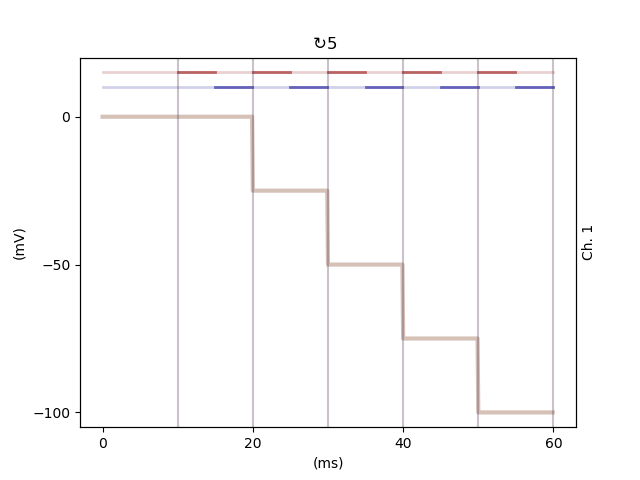

In [26]:
fast_ramp_2.sample_rate(10e3)
fast_ramp_2.start_ramp_voltage(0)
fast_ramp_2.finish_ramp_voltage(-0.1)
fast_ramp_2.n_steps(5)  # 30
fast_ramp_2.n_repetitions(5)  # 20
fast_ramp_2.settlement_time(0.005)  # 0.103
fast_ramp_2.lockin_integration_time(0.005)  # 0.021
fast_ramp_2.restart_compensation(2 * fast_ramp_2.settlement_time())

# Convenient vectors for plotting
time_axis_points = fast_ramp_2.get_trigger_moments_vector()
gate_voltage_points = fast_ramp_2.values_vector()

# Sanity check :)
fast_ramp_2.plot_broadbean_sequence()

## Hook up AWG and lock-in's in a class

In [5]:
class AwgLockInVoltageRampSweep(HardwareSweep):
    """
    This class implements "hardware" sweep that is performed by AWG sequencer, 
    and 3 lock-ins are measuring values while AWG is emitting a signal.
    
    Structure of this object:
    * The object of this class holds references to AWG sequencer and to the lock-ins.
    * Moreover, it defines 3 parameters which correspond to the outputs of the 3 lock-ins.
    * The 'run' method implements the actual measurement where lock-ins acquire data
      while the device under measurement is excited by signals from AWG, and the acquired
      data is then available through the 3 parameters presented above.
    """
    
    def __init__(self,
                 name: str,
                 awg_sequencer_obj: Type[AwgSequencer],
                 lockin1: Type[SR86x],
                 lockin2: Type[SR86x],
                 lockin3: Type[SR86x],
                 **kwargs):
        super().__init__(name, **kwargs)
        
        # AWG sequencer
        self.add_submodule(name='awg_sequencer',
                           submodule=awg_sequencer_obj)
        self.delegate_attr_objects = ['awg_sequencer']

        # Lock-in amplifiers
        self.add_submodule(name='lockin1',
                           submodule=lockin1)
        self.add_submodule(name='lockin2',
                           submodule=lockin2)
        self.add_submodule(name='lockin3',
                           submodule=lockin3)
        self._lockins = [self.lockin1, self.lockin2, self.lockin3]
        
        self._capture_variable_name = "X"
        self._setup_capture_config_for_lockins()

        # Parameters that are linked to outputs of lock-in buffers
        self.add_parameter('measured_voltage_at_triggers_lockin_1',
                           DelegateParameter,
                           source=self.lockin1.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 1 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 1 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_2',
                           DelegateParameter,
                           source=self.lockin2.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 2 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 2 amplifier"
                           )
        self.add_parameter('measured_voltage_at_triggers_lockin_3',
                           DelegateParameter,
                           source=self.lockin3.buffer[self._capture_variable_name],
                           label='Voltage output of lock-in amplifier 3 at '
                                 'triggers',
                           unit='V',
                           snapshot_value=False,
                           vals=Numbers(),
                           docstring="This parameter allows access to the data measured by the lockin 3 amplifier"
                           )
        
    @property
    def lockins(self):
        return self._lockins
       
    def _setup_capture_config_for_lockins(self):
        for lockin in self.lockins:
            lockin.input_config('a')  # within "voltage" block
            lockin.buffer.capture_config(self._capture_variable_name)

    def run(self):
        midas_results = []
        try:
            trigger_count = self.awg_sequencer.sequence_gen.n_all_steps()
            
            for lockin in self.lockins:
                lockin.buffer.set_capture_length_to_fit_samples(trigger_count)
                lockin.buffer.start_capture("ONE", "SAMP")
                
            # arm MIDAS to measure
            
            self.awg_sequencer.awg.play()
            
            for lockin in self.lockins:
                lockin.buffer.wait_until_samples_captured(trigger_count)
                lockin.buffer.stop_capture()
                lockin.buffer.get_capture_data(trigger_count)  # this loads data from buffer 
                                                              # to driver's "buffer readout" fields in memory
            midas.capture_1d_trace() 
            midas_results.append(midas.ch1.magnitude().mean())        

#             # Alternatively, this method could have been returning the data 
#             # instead of using the driver's buffer readout
#             # parameters. But in this case, the occuring boilerplate code
#             # within the measurement context manager should be
#             # taken care of (for example, via Wolfgangs MeasurementExt,
#             # HardwareSweepDetector, etc.)
#             voltage_axis_points_dict = {}
#             for lockin in self.lockins:
#                 lockin_data = lockin.buffer.get_capture_data(trigger_count)
#                 voltage_axis_points_dict[lockin.name] = lockin_data[self._capture_variable_name]
#             return voltage_axis_points_dict
        
        finally:
            self.awg_sequencer.awg.stop()
            return midas_results

## Setup a station

In [11]:
import sys
sys.path.append(r'd:/code/stationq/midas')
from pytopo.qctools import instruments as instools
from midas import Midas
midas = instools.create_inst(Midas, 'midas', '169.254.102.25', force_new_instance=True)

Connected to: Sydney Nanoscience Hub MIDAS (serial:0001, firmware:1.0) in 0.03s


In [6]:
awg = instrument_factory(
    AWG5208, "awg", address='TCPIP0::169.254.254.84::inst0::INSTR')

awg_sequencer = OneChannelTwoMarkerAwgSequencer('awg_sequencer_two', awg, fast_ramp_2)

awg_sequencer.send_sequence_and_setup_awg()

Connected to: TEKTRONIX AWG5208 (serial:B020205, firmware:FV:6.0.0242.0) in 66.05s
Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


In [18]:
awg_sequencer = OneChannelTwoMarkerAwgSequencer('awg_sequencer_two', awg, fast_ramp_2)

awg_sequencer.send_sequence_and_setup_awg()

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


In [19]:
awg_sequencer.awg.play()

In [20]:
awg_sequencer.awg.stop()

In [23]:
midas.capture_1d_trace()

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

# Continuation of definitions

## Define a meta-instrument with measurable/interesting paramters

This instrument is interesting as it shows the approach of defining parameters with units, names, and labels that are meaningful from the experiment context, but which are at the same time linked to the parameters of hardware (or semi-hardware) instruments that are facilitating the measurement.

In [8]:
transistor_characterizer = VirtualInstrument("transistor_characterizer")

# Define parameters
v_g_param = DelegateParameter(
    'v_g', 
    fast_ramp.values_with_repetitions_vector, 
    label='Gate voltage', 
    unit='V'
)
add_parameter_to_instrument(v_g_param, transistor_characterizer)

i_avg_param = DelegateParameter(
    'i_avg',
    fast_ramp.all_repetitions_vector,
    label='Index of gate voltage averaging',
    unit='#'
)
add_parameter_to_instrument(i_avg_param, transistor_characterizer)

v_sd_1_param = DelegateParameter(
    'v_sd_1',
    hwsweeper.measured_voltage_at_triggers_lockin_1,
    label='Source-drain current 1 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_1_param, transistor_characterizer)

v_sd_2_param = DelegateParameter(
    'v_sd_2',
    hwsweeper.measured_voltage_at_triggers_lockin_2,
    label='Source-drain current 2 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_2_param, transistor_characterizer)

v_sd_3_param = DelegateParameter(
    'v_sd_3',
    hwsweeper.measured_voltage_at_triggers_lockin_3,
    label='Source-drain current 3 (as voltage)',
    unit='V'
)
add_parameter_to_instrument(v_sd_3_param, transistor_characterizer)

f_acq_param = DelegateParameter(
    'f_acq',
    lockin1.frequency,
    label='Lock-in acquisition frequency', 
    unit='Hz'
)
add_parameter_to_instrument(f_acq_param, transistor_characterizer)

station.add_component(transistor_characterizer)

'transistor_characterizer'

## Set up lock-in's for the measurement

### Main lock-in

In [9]:
lockin1.reference_source("INT")

# Amplitude is high so that the other two lock-in's detect the reference signal
# The device under measurement is secured with a 16kOhm resister
lockin1.amplitude(1)  # [V]
lockin1.sensitivity(1)  # [V]
lockin1.input_range(300e-3)  # [V]

lockin1.adv_filter('ON') # use Gaussian filter (taking into accound our time constants range)
                        # for better filtering instead of RC
lockin1.sync_filter('ON') # also filter out lockin reference frequency harmonics

# these parameters have the most impact on the data quality
lockin1.time_constant(10e-3)  # [s]
lockin1.filter_slope(24)  # [dB]
lockin1.frequency(27.3765)  # [Hz]

### Lock-in 2

In [10]:
lockin2.reference_source("EXT")

lockin2.external_reference_trigger("SIN")
lockin2.external_reference_trigger_input_resistance("1M")

lockin2.sensitivity(lockin1.sensitivity())  # [V]
lockin2.input_range(lockin1.input_range())  # [V]

lockin2.adv_filter(lockin1.adv_filter())
lockin2.sync_filter(lockin1.sync_filter())

# these parameters have the most impact on the data quality
lockin2.time_constant(lockin1.time_constant())  # [s]
lockin2.filter_slope(lockin1.filter_slope())  # [dB]
lockin2.frequency(lockin1.frequency())  # [Hz]

### Lock-in 3

In [11]:
lockin3.reference_source("EXT")

lockin3.external_reference_trigger("SIN")
lockin3.external_reference_trigger_input_resistance("1M")

lockin3.sensitivity(lockin1.sensitivity())  # [V]
lockin3.input_range(lockin1.input_range())  # [V]

lockin3.adv_filter(lockin1.adv_filter())
lockin3.sync_filter(lockin1.sync_filter())

# these parameters have the most impact on the data quality
lockin3.time_constant(lockin1.time_constant())  # [s]
lockin3.filter_slope(lockin1.filter_slope())  # [dB]
lockin3.frequency(lockin1.frequency())  # [Hz]

## Empty cell for playing with objects

## Run measurement and get data
A special function has been implemented in the buffer of the lock-in amplifier. This function arms the lock-in so that it is ready to capture 1 sample per trigger signal, then it calls the given callable function that launches the pulse train of the triggers, waits until the requested number of samples is acquired to the buffer, and retrieves the data from the buffer.

Note that it is convenient to stop the AWG sequence from running, it does not stop itself after the sequence end is reached.

Mikhail: while playing with this setup in order to achieve data that has reasonable accuracy, I found myself adjusting lockin's time constant, lockin's reference signal frequency, and sample rate, settle time, lockin integration time variables. Perhaps, these variables should be the main parameters of this meta instrument.

In [12]:
measurement = Measurement(experiment, station)
# measurement.write_period = 2

# Register parameters
measurement.register_parameter(v_g_param)
measurement.register_parameter(i_avg_param)
measurement.register_parameter(f_acq_param)
measurement.register_parameter(v_sd_1_param, setpoints=(v_g_param, i_avg_param, f_acq_param))
measurement.register_parameter(v_sd_2_param, setpoints=(v_g_param, i_avg_param, f_acq_param))
measurement.register_parameter(v_sd_3_param, setpoints=(v_g_param, i_avg_param, f_acq_param))

measurement.add_before_run(awg_sequencer.send_sequence_and_setup_awg, ())

# Perform the experiment and save acquired data
with measurement.run() as data_saver:
    
    data_saver.dataset.subscribe(
        LivePlotSubscriber(data_saver.dataset),
        state=[], min_wait=0, min_count=1
    )
    
    for lock_in_frequency in np.linspace(10, 40, 4):
        f_acq_param.set(lock_in_frequency)
    
        # The "hardware sweep"
        hwsweeper.run()  # <-- the long measurement

        # Extract data from parameters
        all_gate_voltage_points = v_g_param.get()  # <-- just calculating a vector
        all_averaging_index_points = i_avg_param.get()  # <-- just calculating a vector
        source_drain_voltage_1_points = v_sd_1_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_2_points = v_sd_2_param.get()  # <-- reading from driver's buffer readout fields
        source_drain_voltage_3_points = v_sd_3_param.get()  # <-- reading from driver's buffer readout fields

        # Save data
        # Note that adding scalars (f_acq_param) next to arrays of the same size IS supported by data_saver
        data_saver.add_result(
            (f_acq_param, lock_in_frequency),
            (v_g_param, all_gate_voltage_points),
            (i_avg_param, all_averaging_index_points),
            (v_sd_1_param, source_drain_voltage_1_points),
            (v_sd_2_param, source_drain_voltage_2_points),
            (v_sd_3_param, source_drain_voltage_3_points),
        )

# Convenient to have for plotting
run_id_of_data = data_saver.run_id

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]
Starting experimental run with id: 27


## Plot all acquired data (from database)

In [12]:
# ax, cbax = plot_by_id(run_id_of_data)

## Plot all acquired data (from memory)

<IPython.core.display.Javascript object>


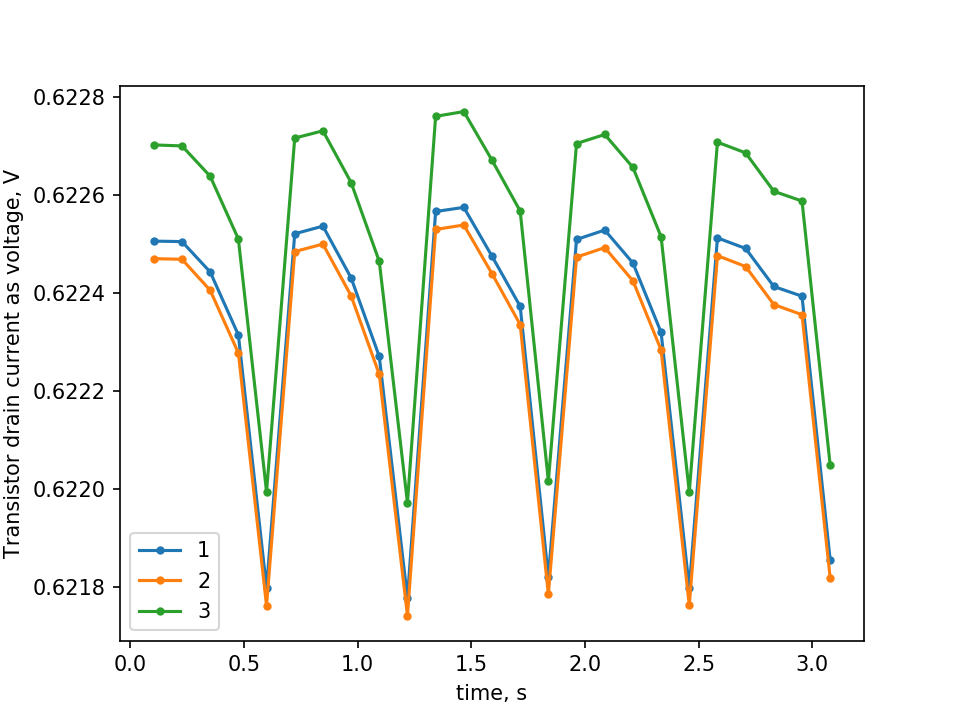

Text(0,0.5,'Transistor drain current as voltage, V')

In [13]:
plt.figure()
plt.plot(time_axis_points, source_drain_voltage_1_points, '.-', label='1')
plt.plot(time_axis_points, source_drain_voltage_2_points, '.-', label='2')
plt.plot(time_axis_points, source_drain_voltage_3_points, '.-', label='3')
plt.legend()
plt.xlabel('time, s')
plt.ylabel('Transistor drain current as voltage, V')

## Average acquired data for accuracy
This is an example of data post-processing for which this "hard sweep" is being designed for.

First let's plot source-drain current values averaged over the number of executed sequences.

<IPython.core.display.Javascript object>


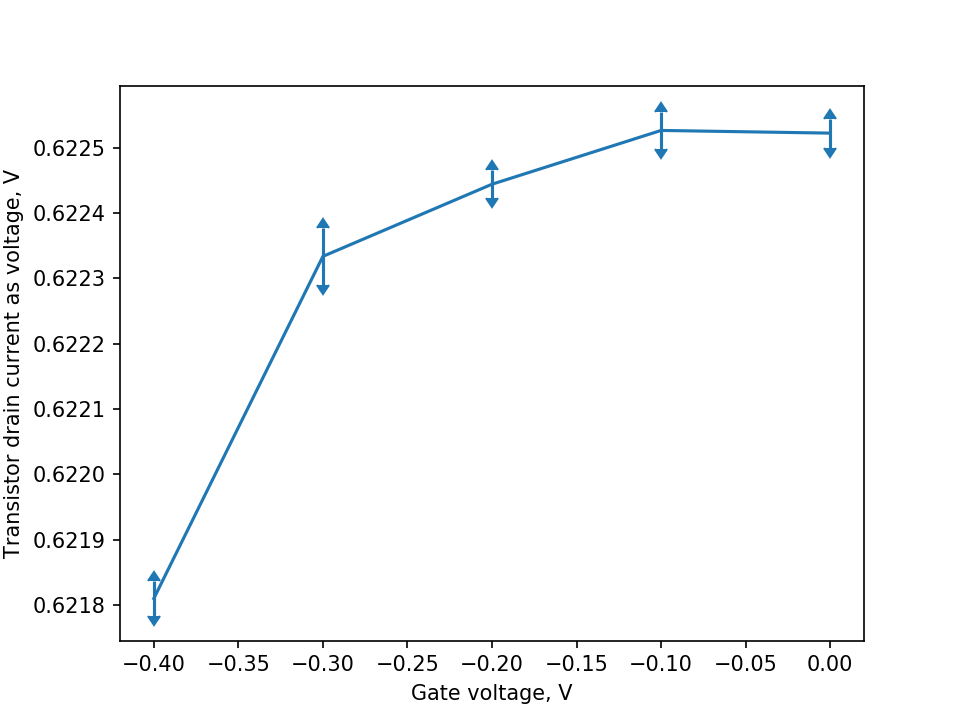

Text(0,0.5,'Transistor drain current as voltage, V')

In [14]:
source_drain_voltage_points = source_drain_voltage_1_points

voltages_matrix = source_drain_voltage_points.reshape((fast_ramp.n_repetitions(), fast_ramp.n_steps()))
averaged_voltage_points = voltages_matrix.mean(0)
averaged_voltage_points_error = voltages_matrix.std(0)

fig, ax = plt.subplots()
ax.errorbar(gate_voltage_points, averaged_voltage_points, yerr=averaged_voltage_points_error,
            lolims=True, uplims=True)

plt.xlabel('Gate voltage, V')
plt.ylabel('Transistor drain current as voltage, V')

Now let's make a more explicit plot of SNR where signal is the source-drain current, and noise is the STD of it.

<IPython.core.display.Javascript object>


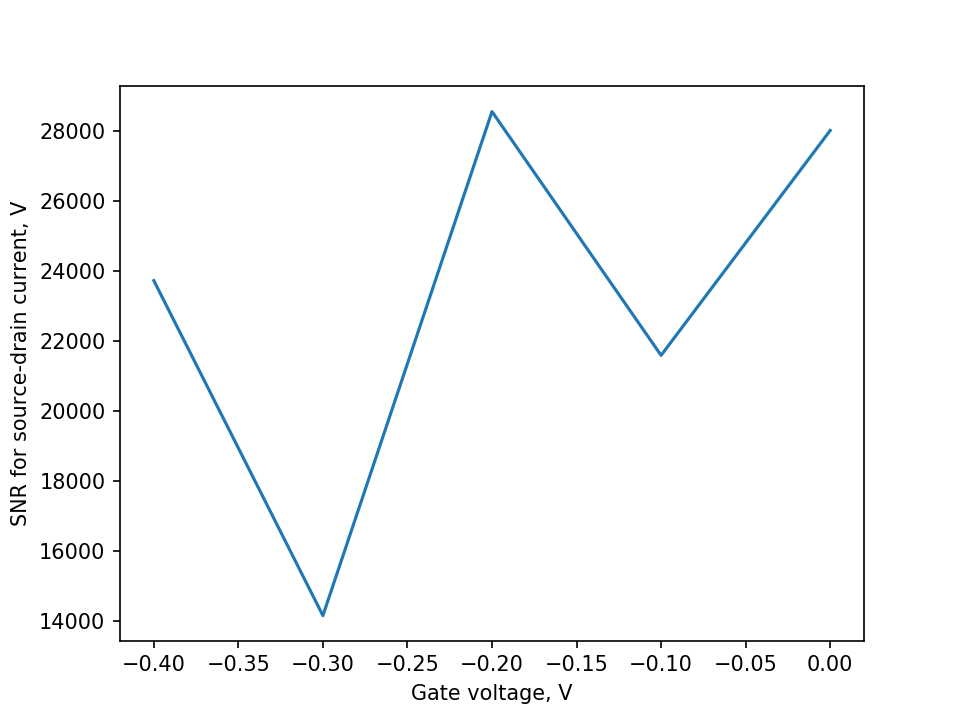

Text(0,0.5,'SNR for source-drain current, V')

In [15]:
averaged_voltage_SNR = averaged_voltage_points / averaged_voltage_points_error

fig, ax = plt.subplots()
plt.plot(gate_voltage_points, averaged_voltage_SNR)

plt.xlabel('Gate voltage, V')
plt.ylabel('SNR for source-drain current, V')

Now let's plot the behavior of standard deviation of the source-drain current with respect to the number of averages (i.e. number of repetitions). There is a line for each gate voltage, which we plot in different colors. 

<IPython.core.display.Javascript object>


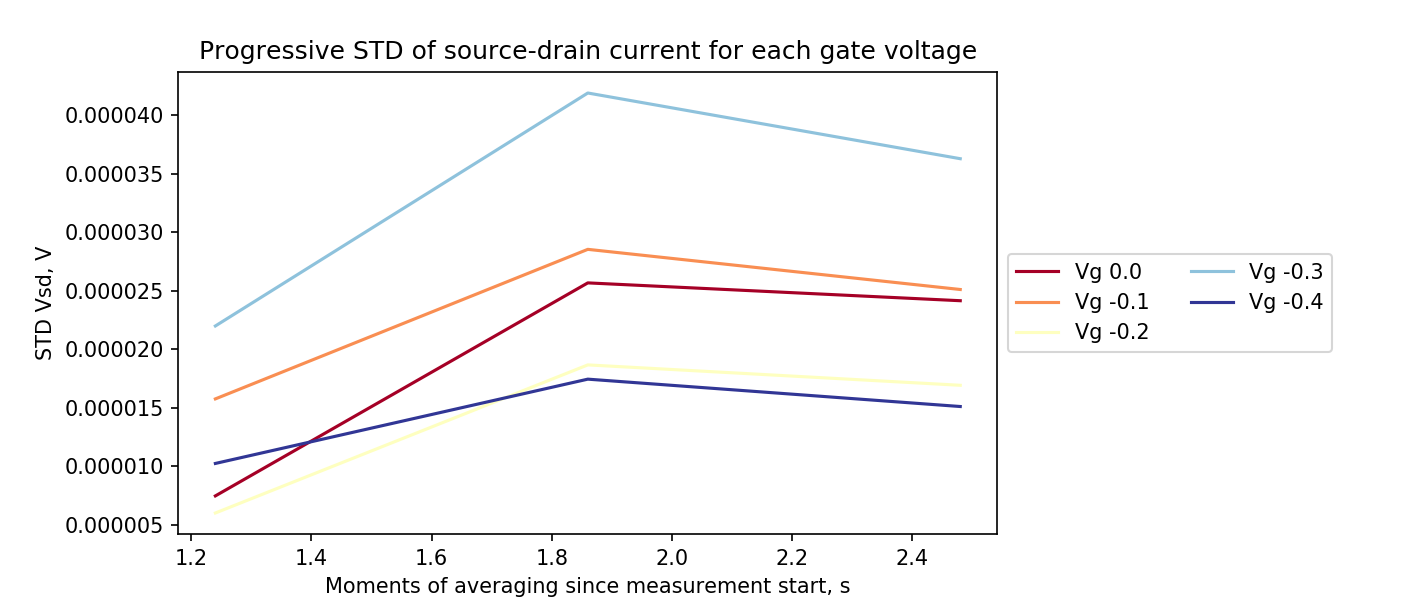

In [16]:
n_averages_vector = np.arange(2, fast_ramp.n_repetitions())
averaging_timestamps = n_averages_vector * fast_ramp.step_duration() * fast_ramp.n_steps()

std_progress = np.empty((fast_ramp.n_repetitions() - 2, fast_ramp.n_steps()))
for end in n_averages_vector:
    std_progress[end - 2, :] = voltages_matrix[:end, :].std(0)
    
fig = plt.figure(figsize=(9.5, 4))

color = iter(cm.rainbow(np.linspace(0, 1, fast_ramp.n_steps())))
c = next(color)

# plots = plt.plot(n_averages_vector, std_progress)
plots = plt.plot(averaging_timestamps, std_progress)

plt.title('Progressive STD of source-drain current for each gate voltage')
# plt.xlabel('Number of averages, #')
plt.xlabel('Moments of averaging since measurement start, s')
plt.ylabel('STD Vsd, V')

for vg, plot in zip(gate_voltage_points, plots):
    i = np.abs(vg) / np.abs(fast_ramp.start_ramp_voltage()-fast_ramp.finish_ramp_voltage())
    plot.set_color(cm.RdYlBu(i))

plt.legend(plots, ["Vg {:.2}".format(i) for i in gate_voltage_points], 
           loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

fig.subplots_adjust(right=0.7)

# Miscellaneous

## A helper measurement that collects MANY samples starting from a trigger
NOT 1 sample PER 1 trigger, BUT N samples starting from 1 trigger

<IPython.core.display.Javascript object>


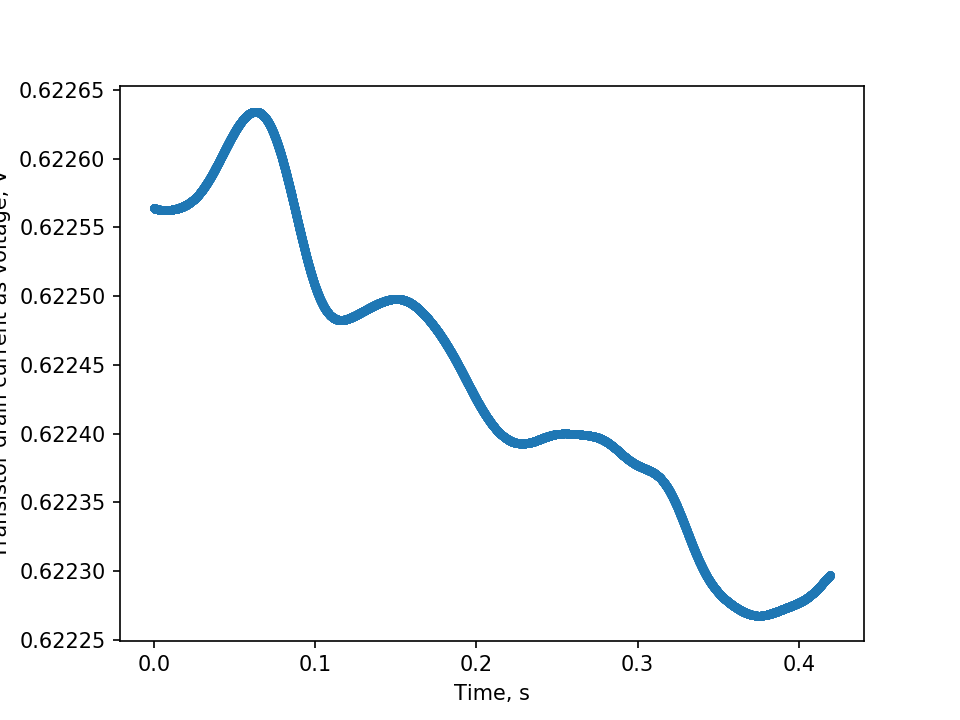

Text(0,0.5,'Transistor drain current as voltage, V')

In [17]:
num_of_sample_to_acquire = int(64*1024/lockin1.buffer.bytes_per_sample)
lockin1.buffer.set_capture_rate_to_maximum()

try:
    raw_data_all = lockin1.buffer.start_capture_at_trigger(
        num_of_sample_to_acquire,  # number of samples to acquire
        awg.play  # launches the trigger pulse train
    )
finally:
    awg.stop()

raw_data = raw_data_all["X"]
    
time_axis = np.arange(len(raw_data)) * 1/lockin1.buffer.capture_rate()

plt.figure()
plt.plot(time_axis, raw_data, '.-')
# plt.xlabel('Sample #, S')
plt.xlabel('Time, s')
plt.ylabel('Transistor drain current as voltage, V')